# Taller No. 1 - Algoritmos de Clustering y Aprendizaje No Supervisado

Implementar y evaluar algoritmos de clustering (K-means y SOM) para dos conjuntos de datos diferentes, aplicando técnicas de análisis no supervisado y semi-supervisado.

## Importación de librerías necesarias

Importamos todas las librerías que utilizaremos durante el análisis.

In [1]:
# Librerías básicas para manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Librerías para clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Para cargar archivos .mat
from scipy.io import loadmat

# Para SOM (se instalará si es necesario)
try:
    from minisom import MiniSom
except ImportError:
    print("MiniSom no está instalado. Instalando...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'minisom'])
    from minisom import MiniSom

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("Todas las librerías importadas exitosamente")

Todas las librerías importadas exitosamente


# Punto 1: Análisis del dataset "data_clusters.mat"

**Objetivo**: Identificar el número óptimo de neuronas en el SOM y de clusters usando K-means que mejor se ajusten al problema.

## Carga y exploración inicial de los datos

In [2]:
# Cargar el archivo .mat desde el directorio material_clase
mat_data = loadmat('../material_clase/data_clusters.mat')
X = mat_data['X']

print("Forma del conjunto de datos:", X.shape)
print("Estadísticas descriptivas:")
print(f"X1 - Media: {X[:, 0].mean():.4f}, Desv.Std: {X[:, 0].std():.4f}")
print(f"X2 - Media: {X[:, 1].mean():.4f}, Desv.Std: {X[:, 1].std():.4f}")
print(f"Rango X1: [{X[:, 0].min():.4f}, {X[:, 0].max():.4f}]")
print(f"Rango X2: [{X[:, 1].min():.4f}, {X[:, 1].max():.4f}]")

Forma del conjunto de datos: (136, 2)
Estadísticas descriptivas:
X1 - Media: 281.0147, Desv.Std: 143.5133
X2 - Media: 190.9191, Desv.Std: 102.7550
Rango X1: [14.0000, 514.0000]
Rango X2: [13.0000, 370.0000]


## Visualización inicial de los datos

Visualizamos los datos en un scatter plot para identificar posibles agrupamientos naturales.

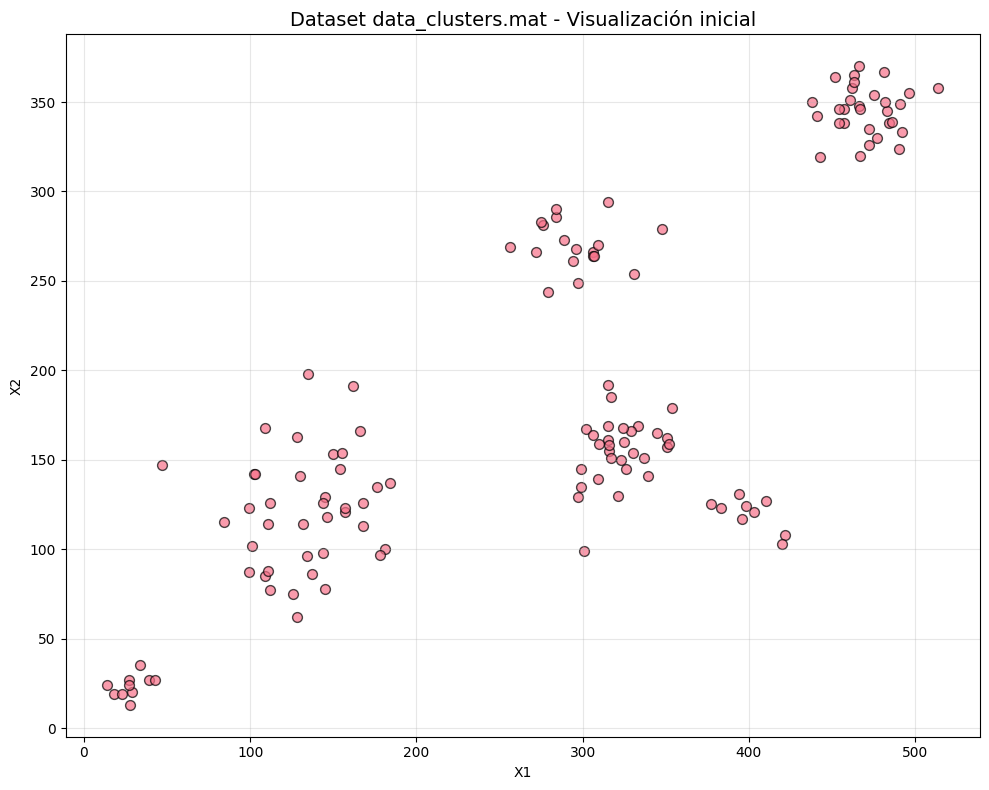

Análisis estadístico detallado:
----------------------------------------
X1:
  Min: 14.00
  Max: 514.00
  Media: 281.01
  Mediana: 306.50
  Desviación estándar: 143.51

X2:
  Min: 13.00
  Max: 370.00
  Media: 190.92
  Mediana: 158.50
  Desviación estándar: 102.75



In [3]:
# Visualización inicial de los datos
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.7, edgecolor='black')
plt.title("Dataset data_clusters.mat - Visualización inicial", fontsize=14)
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis estadístico básico
print("Análisis estadístico detallado:")
print("-" * 40)
for i, feature in enumerate(['X1', 'X2']):
    print(f"{feature}:")
    print(f"  Min: {X[:, i].min():.2f}")
    print(f"  Max: {X[:, i].max():.2f}")
    print(f"  Media: {X[:, i].mean():.2f}")
    print(f"  Mediana: {np.median(X[:, i]):.2f}")
    print(f"  Desviación estándar: {X[:, i].std():.2f}")
    print()

## 1.1 Análisis de K-means - Selección del número óptimo de clusters

Utilizamos el método del codo y coeficiente de silhouette para determinar el número óptimo de clusters.

Evaluando diferentes números de clusters...
K=2: Inercia=1454896.79, Silhouette=0.5826
K=3: Inercia=548269.02, Silhouette=0.6683
K=4: Inercia=337989.50, Silhouette=0.6924
K=5: Inercia=171425.02, Silhouette=0.7030
K=6: Inercia=120685.82, Silhouette=0.7087
K=7: Inercia=89826.66, Silhouette=0.6464
K=8: Inercia=77782.01, Silhouette=0.6337
K=9: Inercia=66354.95, Silhouette=0.6475
K=10: Inercia=60024.01, Silhouette=0.5682


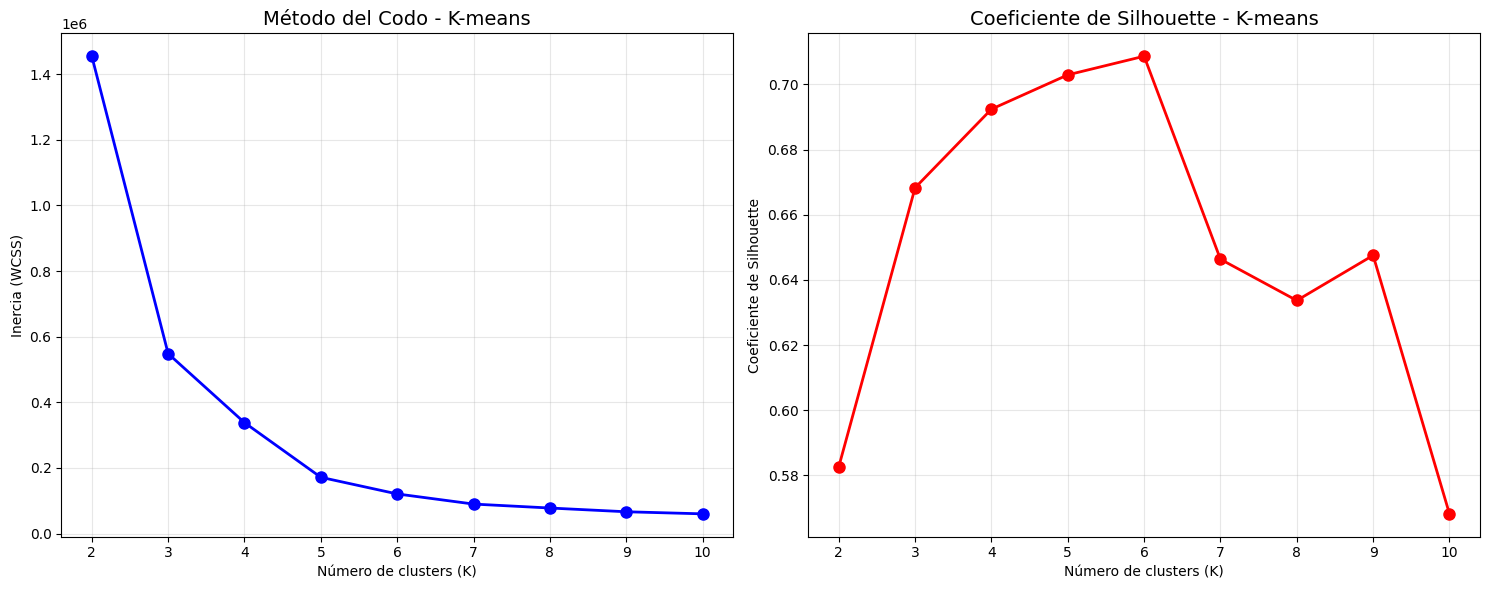


Mejor K según coeficiente de silhouette: 6
Puntuación de silhouette: 0.7087


In [4]:
# Análisis de K-means: Método del codo y coeficiente de silhouette
inertias = []
silhouette_scores = []
k_range = range(2, 11)

print("Evaluando diferentes números de clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.4f}")

# Visualización de resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Método del codo
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Método del Codo - K-means', fontsize=14)
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inercia (WCSS)')
ax1.grid(True, alpha=0.3)

# Coeficiente de silhouette
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Coeficiente de Silhouette - K-means', fontsize=14)
ax2.set_xlabel('Número de clusters (K)')
ax2.set_ylabel('Coeficiente de Silhouette')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar el mejor K basado en silhouette
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\nMejor K según coeficiente de silhouette: {best_k_silhouette}")
print(f"Puntuación de silhouette: {max(silhouette_scores):.4f}")

## Visualización de clustering K-means con K óptimo

Aplicamos K-means con el número óptimo de clusters identificado (K=6).

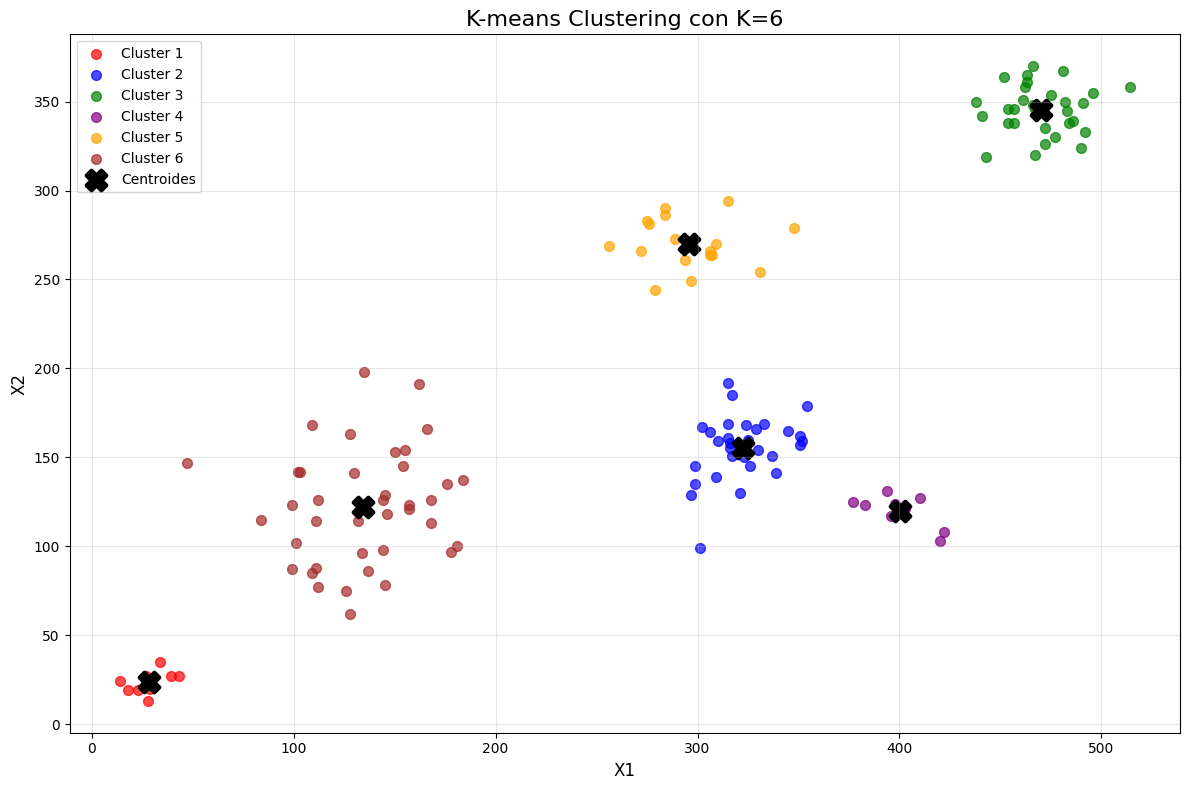

Resultados del clustering K-means (K=6):
--------------------------------------------------
Cluster 1: 10 puntos, Centroide: (28.20, 23.50)
Cluster 2: 30 puntos, Centroide: (322.47, 155.47)
Cluster 3: 30 puntos, Centroide: (470.20, 345.50)
Cluster 4: 9 puntos, Centroide: (400.33, 119.89)
Cluster 5: 18 puntos, Centroide: (295.78, 270.06)
Cluster 6: 39 puntos, Centroide: (134.08, 122.08)


In [5]:
# Aplicar K-means con el número óptimo de clusters
best_k = 6
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels_final = kmeans_final.fit_predict(X)

# Visualización del clustering final
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(best_k):
    cluster_points = X[cluster_labels_final == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=colors[i], label=f'Cluster {i+1}', s=50, alpha=0.7)

# Mostrar centroides
centroids = kmeans_final.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            c='black', marker='X', s=200, linewidths=3, label='Centroides')

plt.title(f'K-means Clustering con K={best_k}', fontsize=16)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Información de los clusters
print(f"Resultados del clustering K-means (K={best_k}):")
print("-" * 50)
for i in range(best_k):
    cluster_size = np.sum(cluster_labels_final == i)
    centroid = centroids[i]
    print(f"Cluster {i+1}: {cluster_size} puntos, Centroide: ({centroid[0]:.2f}, {centroid[1]:.2f})")

## 1.2 Análisis SOM (Self-Organizing Maps)

Evaluamos diferentes tamaños de rejilla para encontrar el número óptimo de neuronas en el SOM.

Evaluación de diferentes tamaños de SOM:
------------------------------------------------------------
Tamaño		Neuronas Totales	Neuronas Activas	Error Cuantización
------------------------------------------------------------
3x3		9			7			0.0547
4x4		16			13			0.0393
5x5		25			19			0.0325
6x6		36			28			0.0283
7x7		49			35			0.0241
8x8		64			39			0.0241


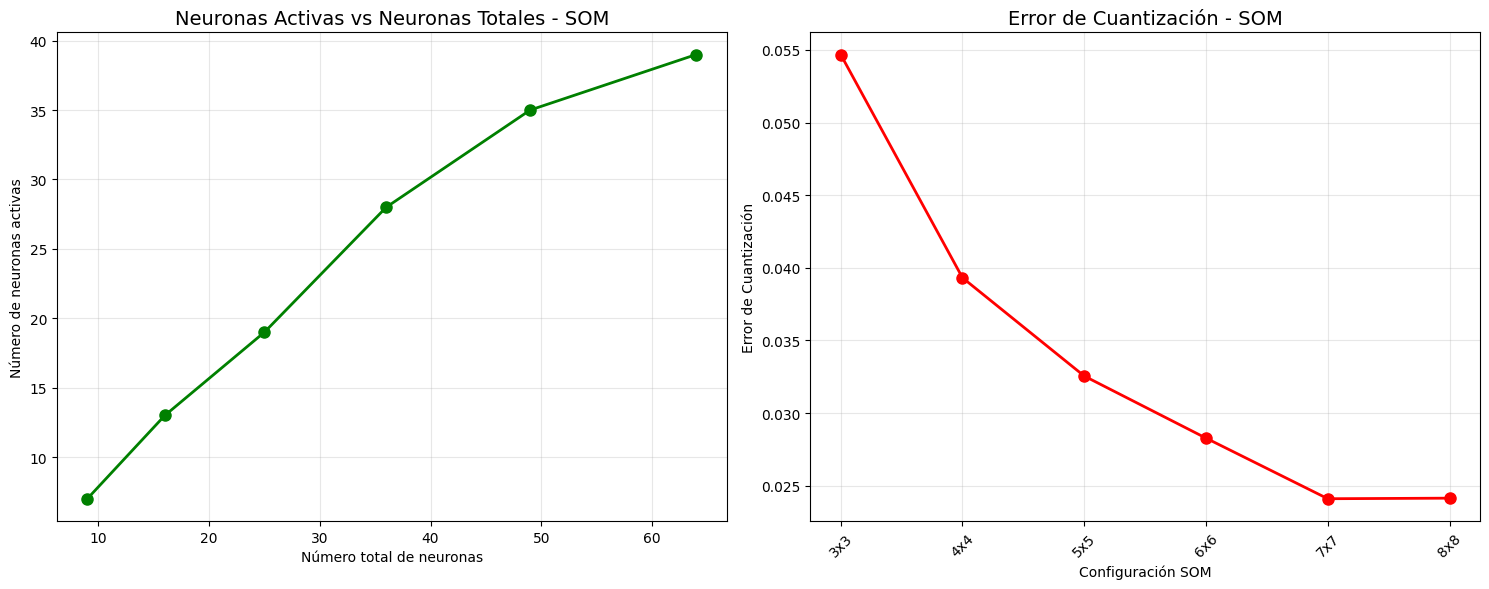

In [6]:
# Normalización de los datos para SOM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Función para evaluar diferentes tamaños de SOM
def evaluar_som(dim_x, dim_y, datos, num_iteraciones=1000):
    som = MiniSom(dim_x, dim_y, datos.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
    som.train(datos, num_iteraciones)
    
    # Obtener BMUs (Best Matching Units)
    bmus = [som.winner(x) for x in datos]
    neuronas_activas = len(set(bmus))
    
    # Calcular error de cuantización
    error_cuantizacion = som.quantization_error(datos)
    
    return neuronas_activas, error_cuantizacion, som

# Evaluar diferentes tamaños de SOM
tamaños_som = [(3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]
resultados_som = []

print("Evaluación de diferentes tamaños de SOM:")
print("-" * 60)
print("Tamaño\t\tNeuronas Totales\tNeuronas Activas\tError Cuantización")
print("-" * 60)

for dim_x, dim_y in tamaños_som:
    neuronas_activas, error_cuant, som_temp = evaluar_som(dim_x, dim_y, X_normalized)
    neuronas_totales = dim_x * dim_y
    
    resultados_som.append({
        'dimension': (dim_x, dim_y),
        'neuronas_totales': neuronas_totales,
        'neuronas_activas': neuronas_activas,
        'error_cuantizacion': error_cuant,
        'som': som_temp
    })
    
    print(f"{dim_x}x{dim_y}\t\t{neuronas_totales}\t\t\t{neuronas_activas}\t\t\t{error_cuant:.4f}")

# Visualización de resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de neuronas activas vs totales
neuronas_totales = [r['neuronas_totales'] for r in resultados_som]
neuronas_activas = [r['neuronas_activas'] for r in resultados_som]

ax1.plot(neuronas_totales, neuronas_activas, 'go-', linewidth=2, markersize=8)
ax1.set_title('Neuronas Activas vs Neuronas Totales - SOM', fontsize=14)
ax1.set_xlabel('Número total de neuronas')
ax1.set_ylabel('Número de neuronas activas')
ax1.grid(True, alpha=0.3)

# Gráfico de error de cuantización
errores = [r['error_cuantizacion'] for r in resultados_som]
dimensiones = [f"{r['dimension'][0]}x{r['dimension'][1]}" for r in resultados_som]

ax2.plot(range(len(errores)), errores, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Error de Cuantización - SOM', fontsize=14)
ax2.set_xlabel('Configuración SOM')
ax2.set_ylabel('Error de Cuantización')
ax2.set_xticks(range(len(dimensiones)))
ax2.set_xticklabels(dimensiones, rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualización del SOM óptimo y análisis detallado

Seleccionamos la configuración SOM 7x7 por su balance entre error bajo y eficiencia computacional.

Configuración SOM seleccionada: 7x7
Neuronas activas: 35/49
Error de cuantización: 0.0241


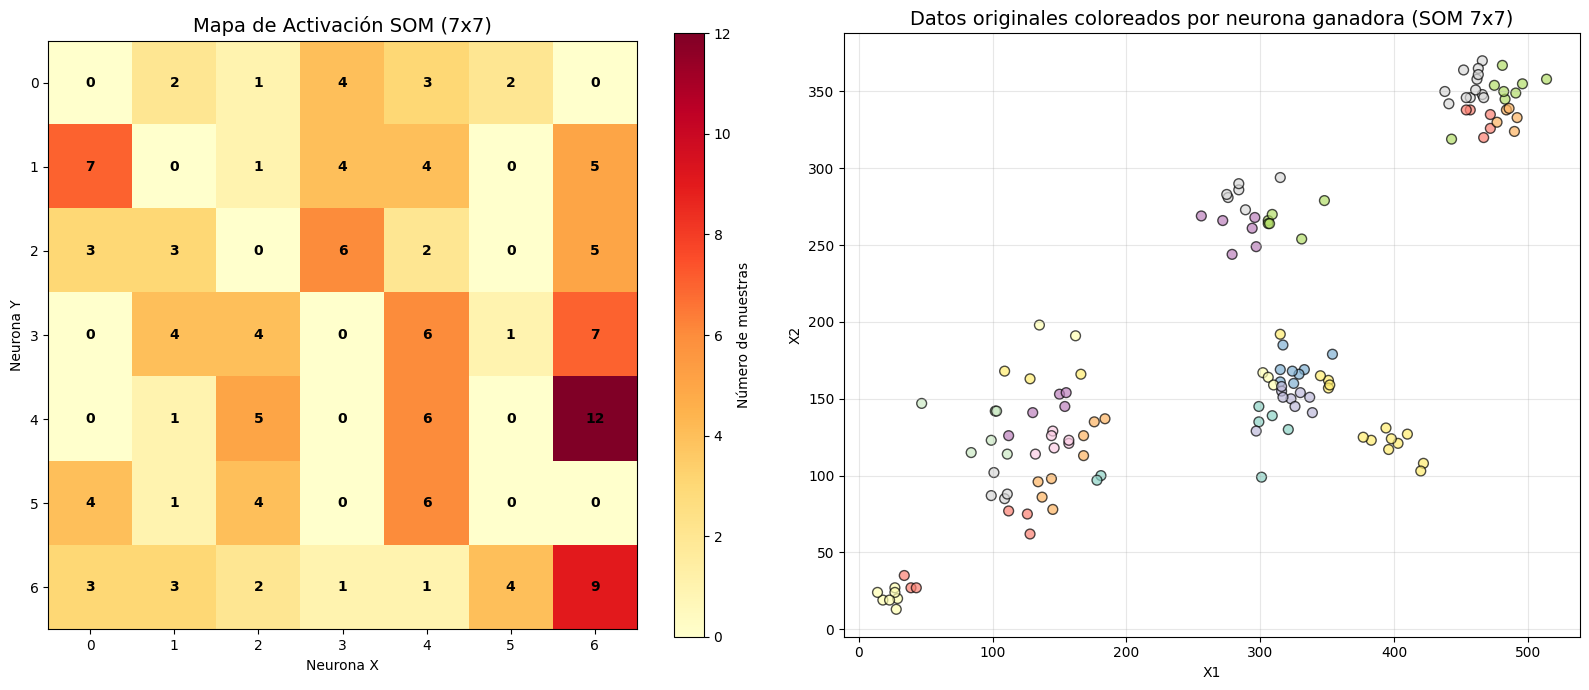


Neuronas que recibieron al menos una muestra: 35
Posiciones de neuronas activas: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 0], [1, 2], [1, 3], [1, 4], [1, 6], [2, 0], [2, 1], [2, 3], [2, 4], [2, 6], [3, 1], [3, 2], [3, 4], [3, 5], [3, 6], [4, 1], [4, 2], [4, 4], [4, 6], [5, 0], [5, 1], [5, 2], [5, 4], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6]]


In [7]:
# Seleccionar el SOM óptimo (7x7)
som_optimo = resultados_som[4]['som']  # 7x7 está en el índice 4
print("Configuración SOM seleccionada: 7x7")
print(f"Neuronas activas: {resultados_som[4]['neuronas_activas']}/49")
print(f"Error de cuantización: {resultados_som[4]['error_cuantizacion']:.4f}")

# Obtener BMUs para cada punto
winners = [som_optimo.winner(x) for x in X_normalized]

# Visualización del mapeo SOM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Mapa de activación de neuronas
activation_map = np.zeros((7, 7))
for winner in winners:
    activation_map[winner] += 1

im1 = ax1.imshow(activation_map, cmap='YlOrRd', interpolation='nearest')
ax1.set_title('Mapa de Activación SOM (7x7)', fontsize=14)
ax1.set_xlabel('Neurona X')
ax1.set_ylabel('Neurona Y')

# Agregar valores en las celdas
for i in range(7):
    for j in range(7):
        ax1.text(j, i, f'{int(activation_map[i, j])}', 
                ha='center', va='center', fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Número de muestras')

# Visualización de clusters en el espacio original con colores por neurona ganadora
colors_som = plt.cm.Set3(np.linspace(0, 1, 49))  # 49 colores posibles
winner_colors = [colors_som[winner[0] * 7 + winner[1]] for winner in winners]

scatter = ax2.scatter(X[:, 0], X[:, 1], c=winner_colors, s=50, alpha=0.7, edgecolor='black')
ax2.set_title('Datos originales coloreados por neurona ganadora (SOM 7x7)', fontsize=14)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de neuronas activas
neuronas_con_datos = np.unique(winners, axis=0)
print(f"\nNeuronas que recibieron al menos una muestra: {len(neuronas_con_datos)}")
print("Posiciones de neuronas activas:", neuronas_con_datos.tolist())

## Conclusiones del Punto 1

### Experimentación realizada:
1. **K-means**: Evaluamos K de 2 a 10 usando método del codo y coeficiente de silhouette
2. **SOM**: Probamos rejillas desde 3x3 hasta 8x8, analizando neuronas activas y error de cuantización

### Resultados óptimos:
- **K-means**: K=6 clusters con coeficiente de silhouette = 0.7087
- **SOM**: Rejilla 7x7 (49 neuronas totales, 35 activas) con error de cuantización = 0.0241

### Justificación:
- Para K-means: K=6 maximiza la cohesión interna y separación entre clusters
- Para SOM: 7x7 ofrece el mejor balance entre precisión de representación y eficiencia computacional

# Punto 2: Análisis del dataset Avila (UCI)

**Objetivo**: Diseñar modelos de clustering no supervisados (K-means y SOM) para clasificación del copista de manuscritos del siglo XII, aplicando enfoque semi-supervisado con validación cruzada.

## 2.1 Carga y exploración del dataset Avila

In [8]:
# Cargar dataset Avila
# Nombres de las columnas según la descripción del dataset UCI
column_names = [
    'intercolumnar_distance', 'upper_margin', 'lower_margin', 'exploitation',
    'row_number', 'modular_ratio', 'interlinear_spacing', 'weight',
    'peak_number', 'modular_interlinear_ratio', 'class'
]

# Cargar archivos de entrenamiento y test
df_train = pd.read_csv('avila/avila-tr.txt', header=None, names=column_names)
df_test = pd.read_csv('avila/avila-ts.txt', header=None, names=column_names)

# Combinar datasets para análisis completo
df_avila = pd.concat([df_train, df_test], ignore_index=True)

print("Información general del dataset Avila:")
print(f"Dimensiones: {df_avila.shape}")
print(f"Número de características: {df_avila.shape[1] - 1}")  # -1 por la columna clase
print(f"Archivo entrenamiento: {df_train.shape[0]} muestras")
print(f"Archivo test: {df_test.shape[0]} muestras")
print(f"Total: {df_avila.shape[0]} muestras")

print("\nPrimeras 5 filas del dataset:")
df_avila.head()

Información general del dataset Avila:
Dimensiones: (20867, 11)
Número de características: 10
Archivo entrenamiento: 10430 muestras
Archivo test: 10437 muestras
Total: 20867 muestras

Primeras 5 filas del dataset:


,intercolumnar_distance,upper_margin,lower_margin,exploitation,row_number,modular_ratio,interlinear_spacing,weight,peak_number,modular_interlinear_ratio,class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


Distribución de clases (copistas):
class
A    8572
F    3923
E    2190
I    1663
X    1044
H    1039
G     893
D     705
Y     533
C     206
W      89
B      10
Name: count, dtype: int64

Número de clases diferentes: 12


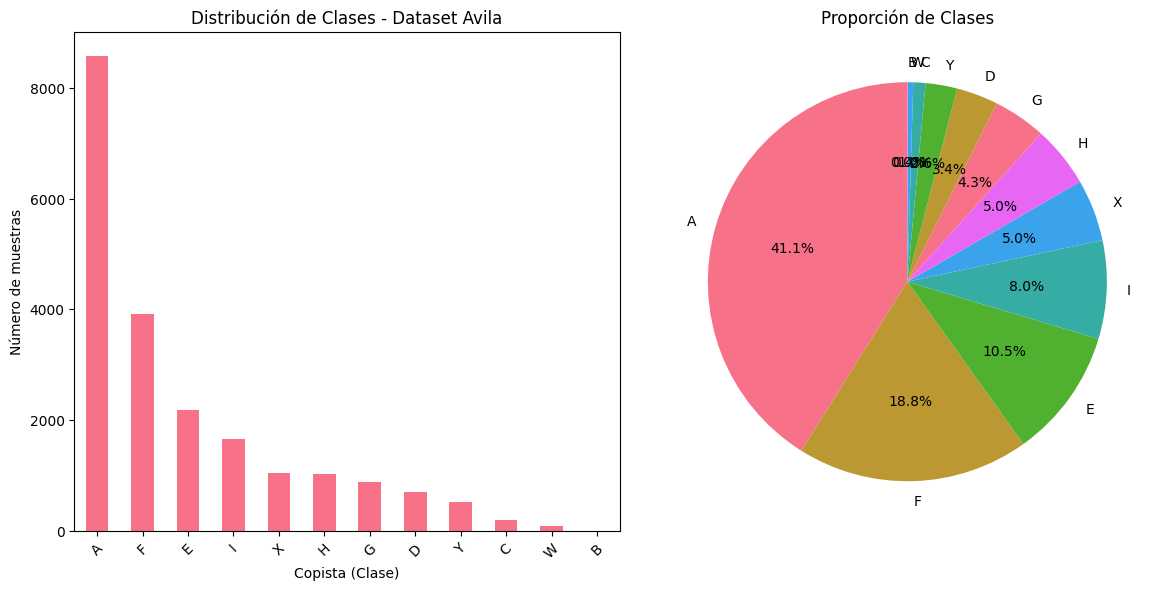


Las 4 clases con menor cantidad de datos:
Clase Y: 533 muestras (2.55%)
Clase C: 206 muestras (0.99%)
Clase W: 89 muestras (0.43%)
Clase B: 10 muestras (0.05%)


In [9]:
# Análisis de distribución de clases
class_counts = df_avila['class'].value_counts().sort_values(ascending=False)
print("Distribución de clases (copistas):")
print(class_counts)
print(f"\nNúmero de clases diferentes: {len(class_counts)}")

# Visualización de la distribución de clases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Distribución de Clases - Dataset Avila')
plt.xlabel('Copista (Clase)')
plt.ylabel('Número de muestras')
plt.xticks(rotation=45)

# Gráfico circular para mejor visualización
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Clases')
plt.tight_layout()
plt.show()

# Identificar las 4 clases con menor cantidad de datos
clases_menores = class_counts.tail(4)
print(f"\nLas 4 clases con menor cantidad de datos:")
for clase, cantidad in clases_menores.items():
    print(f"Clase {clase}: {cantidad} muestras ({cantidad/len(df_avila)*100:.2f}%)")

## 2.2 Preprocesamiento: Eliminación de clases menores

Eliminamos las 4 clases con menor cantidad de datos (Y, C, W, B) para simplificar el análisis.

In [10]:
# Eliminar las 4 clases con menor cantidad de datos
clases_a_eliminar = ['Y', 'C', 'W', 'B']
df_avila_filtrado = df_avila[~df_avila['class'].isin(clases_a_eliminar)].copy()

print(f"Dataset original: {df_avila.shape[0]} muestras, {len(df_avila['class'].unique())} clases")
print(f"Dataset filtrado: {df_avila_filtrado.shape[0]} muestras, {len(df_avila_filtrado['class'].unique())} clases")

# Nueva distribución de clases
class_counts_filtrado = df_avila_filtrado['class'].value_counts().sort_values(ascending=False)
print("\nNueva distribución de clases:")
print(class_counts_filtrado)

# Preparar características (X) y etiquetas (y)
X_avila = df_avila_filtrado.drop('class', axis=1)
y_avila = df_avila_filtrado['class']

print(f"\nDimensiones finales:")
print(f"X: {X_avila.shape}")
print(f"y: {len(y_avila.unique())} clases únicas")

# Mostrar estadísticas de las características
print("\nEstadísticas descriptivas de las características:")
print(X_avila.describe().round(4))

Dataset original: 20867 muestras, 12 clases
Dataset filtrado: 20029 muestras, 8 clases

Nueva distribución de clases:
class
A    8572
F    3923
E    2190
I    1663
X    1044
H    1039
G     893
D     705
Name: count, dtype: int64

Dimensiones finales:
X: (20029, 10)
y: 8 clases únicas

Estadísticas descriptivas de las características:
       intercolumnar_distance  upper_margin  lower_margin  exploitation  \
count              20029.0000    20029.0000    20029.0000    20029.0000   
mean                   0.0214        0.0088       -0.0072       -0.0225   
std                    0.9932        2.8762        1.0360        0.9896   
min                   -3.4988       -2.4268       -3.2105       -5.4401   
25%                   -0.1166       -0.2598        0.0614       -0.5426   
50%                    0.0562       -0.0557        0.2143        0.0723   
75%                    0.2167        0.2034        0.3459        0.6001   
max                   11.8199      386.0000       50.0000      

## 2.3 División del dataset

Dividimos el dataset en: 70% entrenamiento, 15% etiquetado (semi-supervisado), 15% validación.

In [11]:
# División estratificada del dataset
# Primera división: 70% entrenamiento, 30% temporal
X_train_avila, X_temp, y_train_avila, y_temp = train_test_split(
    X_avila, y_avila, test_size=0.3, random_state=42, stratify=y_avila
)

# Segunda división: dividir el 30% temporal en 15% etiquetado y 15% validación
X_label_avila, X_val_avila, y_label_avila, y_val_avila = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("División del dataset Avila:")
print(f"Entrenamiento: {X_train_avila.shape[0]} muestras ({X_train_avila.shape[0]/len(df_avila_filtrado)*100:.1f}%)")
print(f"Etiquetado (semi-supervisado): {X_label_avila.shape[0]} muestras ({X_label_avila.shape[0]/len(df_avila_filtrado)*100:.1f}%)")
print(f"Validación: {X_val_avila.shape[0]} muestras ({X_val_avila.shape[0]/len(df_avila_filtrado)*100:.1f}%)")

# Normalización de las características
scaler_avila = StandardScaler()
X_train_avila_scaled = scaler_avila.fit_transform(X_train_avila)
X_label_avila_scaled = scaler_avila.transform(X_label_avila)
X_val_avila_scaled = scaler_avila.transform(X_val_avila)

print(f"\nDatos normalizados correctamente.")
print(f"Rango de características después de normalización:")
print(f"Media: {X_train_avila_scaled.mean(axis=0).round(4)}")
print(f"Desv. Std: {X_train_avila_scaled.std(axis=0).round(4)}")

# Verificar distribución de clases en cada conjunto
print(f"\nDistribución de clases por conjunto:")
print(f"Entrenamiento: {y_train_avila.value_counts().sort_index().to_dict()}")
print(f"Etiquetado: {y_label_avila.value_counts().sort_index().to_dict()}")
print(f"Validación: {y_val_avila.value_counts().sort_index().to_dict()}")

División del dataset Avila:
Entrenamiento: 14020 muestras (70.0%)
Etiquetado (semi-supervisado): 3004 muestras (15.0%)
Validación: 3005 muestras (15.0%)

Datos normalizados correctamente.
Rango de características después de normalización:
Media: [ 0.  0. -0. -0. -0. -0.  0.  0.  0. -0.]
Desv. Std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Distribución de clases por conjunto:
Entrenamiento: {'A': 6000, 'D': 494, 'E': 1533, 'F': 2746, 'G': 625, 'H': 727, 'I': 1164, 'X': 731}
Etiquetado: {'A': 1286, 'D': 106, 'E': 328, 'F': 588, 'G': 134, 'H': 156, 'I': 249, 'X': 157}
Validación: {'A': 1286, 'D': 105, 'E': 329, 'F': 589, 'G': 134, 'H': 156, 'I': 250, 'X': 156}


# 2.4 Modelo K-means con múltiples variaciones

Evaluamos 15 diferentes números de clusters (K) para encontrar la configuración óptima usando coeficiente de silhouette y método del codo.

Evaluación K-means para dataset Avila:
------------------------------------------------------------
K	Inercia		Silhouette	Tiempo (s)
------------------------------------------------------------
2	122386.53		0.4081		5.57
3	107545.69		0.1709		5.96
4	96965.97		0.1807		5.66
5	88186.47		0.1960		5.45
6	81096.62		0.2021		4.76
7	75271.55		0.1710		4.70
8	69847.28		0.2006		4.96
9	65137.30		0.1842		4.89
10	61593.07		0.1874		4.67
11	59200.14		0.1568		4.84
12	57049.56		0.1550		4.71
13	54895.44		0.1588		4.82
14	53612.88		0.1582		4.86
15	51456.71		0.1584		5.06
16	50198.08		0.1576		4.74

Mejor K según coeficiente de silhouette: 2
Mejor puntuación de silhouette: 0.4081


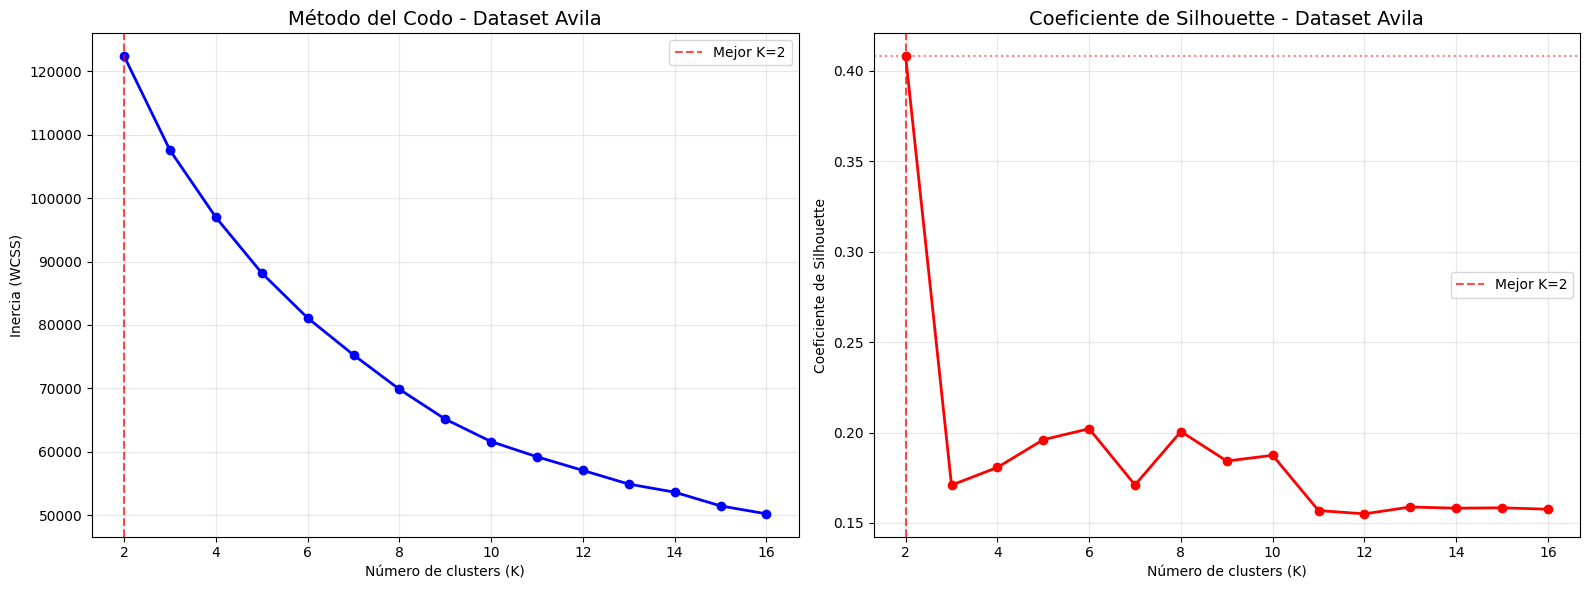

In [12]:
# K-means con múltiples variaciones
k_range_avila = range(2, 17)  # 15 variaciones (k=2 hasta k=16)
inertias_avila = []
silhouette_scores_avila = []
kmeans_models = {}

print("Evaluación K-means para dataset Avila:")
print("-" * 60)
print("K\tInercia\t\tSilhouette\tTiempo (s)")
print("-" * 60)

import time

for k in k_range_avila:
    start_time = time.time()
    
    # Entrenar K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_avila_scaled)
    
    # Calcular métricas
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_train_avila_scaled, cluster_labels)
    
    # Guardar resultados
    inertias_avila.append(inertia)
    silhouette_scores_avila.append(silhouette_avg)
    kmeans_models[k] = kmeans
    
    end_time = time.time()
    
    print(f"{k}\t{inertia:.2f}\t\t{silhouette_avg:.4f}\t\t{end_time-start_time:.2f}")

# Encontrar mejor K por silhouette
best_k_avila = k_range_avila[np.argmax(silhouette_scores_avila)]
best_silhouette = max(silhouette_scores_avila)

print(f"\nMejor K según coeficiente de silhouette: {best_k_avila}")
print(f"Mejor puntuación de silhouette: {best_silhouette:.4f}")

# Visualización de resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Método del codo
ax1.plot(k_range_avila, inertias_avila, 'bo-', linewidth=2, markersize=6)
ax1.set_title('Método del Codo - Dataset Avila', fontsize=14)
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inercia (WCSS)')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=best_k_avila, color='red', linestyle='--', alpha=0.7, label=f'Mejor K={best_k_avila}')
ax1.legend()

# Coeficiente de silhouette
ax2.plot(k_range_avila, silhouette_scores_avila, 'ro-', linewidth=2, markersize=6)
ax2.set_title('Coeficiente de Silhouette - Dataset Avila', fontsize=14)
ax2.set_xlabel('Número de clusters (K)')
ax2.set_ylabel('Coeficiente de Silhouette')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=best_k_avila, color='red', linestyle='--', alpha=0.7, label=f'Mejor K={best_k_avila}')
ax2.axhline(y=best_silhouette, color='red', linestyle=':', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

# 2.5 Modelo SOM con múltiples configuraciones de rejilla

Evaluamos 12 diferentes configuraciones de SOM, analizando neuronas activas y error de cuantización.

Evaluación SOM para dataset Avila (usando 5000 muestras):
--------------------------------------------------------------------------------
Config.	Neuronas	Activas	Error Cuant.	Tiempo (s)
--------------------------------------------------------------------------------
3x3	9		9	1.8957		0.17
4x4	16		16	1.6993		0.10
5x5	25		25	1.5916		0.11
6x6	36		36	1.4904		0.12
7x7	49		49	1.4337		0.15
8x8	64		62	1.3947		0.16
9x9	81		81	1.3517		0.15
10x10	100		95	1.3195		0.20
4x6	24		24	1.5690		0.12
6x8	48		48	1.4350		0.09
8x10	80		79	1.3483		0.17
10x12	120		114	1.3025		0.16

Mejor configuración SOM: 10x12
Error de cuantización: 1.3025
Neuronas activas: 114/120
Eficiencia: 95.00%


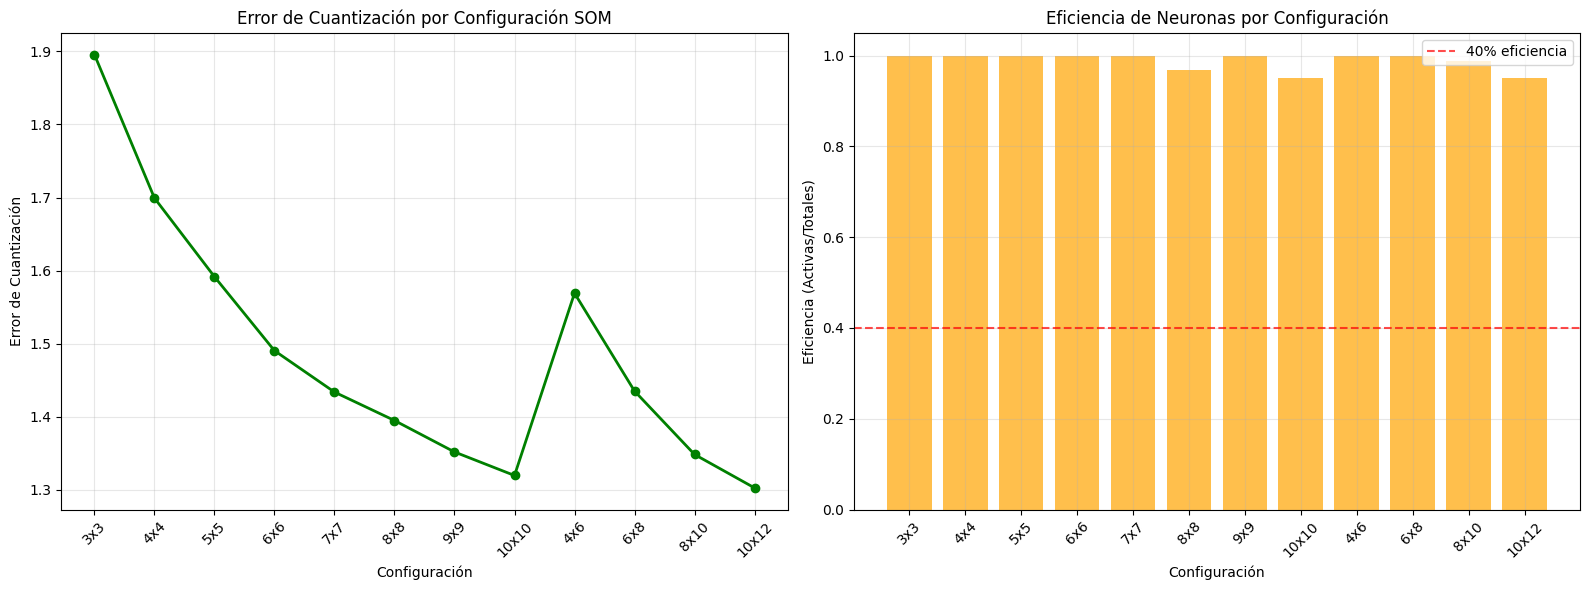

In [13]:
# SOM con múltiples configuraciones de rejilla (versión optimizada)
som_configs = [
    (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8),
    (9, 9), (10, 10), (4, 6), (6, 8), (8, 10), (10, 12)
]

som_results = []
som_models_avila = {}

# Usar submuestra para acelerar entrenamiento SOM
n_samples_som = min(5000, len(X_train_avila_scaled))  # Máximo 5000 muestras
indices_som = np.random.choice(len(X_train_avila_scaled), n_samples_som, replace=False)
X_train_som_subset = X_train_avila_scaled[indices_som]

print(f"Evaluación SOM para dataset Avila (usando {n_samples_som} muestras):")
print("-" * 80)
print("Config.\tNeuronas\tActivas\tError Cuant.\tTiempo (s)")
print("-" * 80)

for som_x, som_y in som_configs:
    start_time = time.time()
    
    # Entrenar SOM con menos iteraciones para eficiencia
    som = MiniSom(som_x, som_y, X_train_som_subset.shape[1], 
                  sigma=1.0, learning_rate=0.5, random_seed=42)
    som.train(X_train_som_subset, num_iteration=500)  # Reducido de 1000 a 500
    
    # Calcular métricas en la submuestra
    bmus = [som.winner(x) for x in X_train_som_subset]
    neuronas_activas = len(set(bmus))
    error_cuantizacion = som.quantization_error(X_train_som_subset)
    neuronas_totales = som_x * som_y
    
    # Guardar resultados
    som_results.append({
        'config': (som_x, som_y),
        'neuronas_totales': neuronas_totales,
        'neuronas_activas': neuronas_activas,
        'error_cuantizacion': error_cuantizacion,
        'eficiencia': neuronas_activas / neuronas_totales,
        'som': som
    })
    
    som_models_avila[(som_x, som_y)] = som
    
    end_time = time.time()
    
    print(f"{som_x}x{som_y}\t{neuronas_totales}\t\t{neuronas_activas}\t{error_cuantizacion:.4f}\t\t{end_time-start_time:.2f}")

# Encontrar mejor configuración (menor error de cuantización con buena eficiencia)
# Filtrar configuraciones con eficiencia > 40% (más permisivo)
configs_eficientes = [r for r in som_results if r['eficiencia'] > 0.4]
if not configs_eficientes:
    configs_eficientes = som_results  # Si no hay configuraciones eficientes, usar todas

mejor_som = min(configs_eficientes, key=lambda x: x['error_cuantizacion'])

print(f"\nMejor configuración SOM: {mejor_som['config'][0]}x{mejor_som['config'][1]}")
print(f"Error de cuantización: {mejor_som['error_cuantizacion']:.4f}")
print(f"Neuronas activas: {mejor_som['neuronas_activas']}/{mejor_som['neuronas_totales']}")
print(f"Eficiencia: {mejor_som['eficiencia']:.2%}")

# Visualización de resultados (versión simplificada)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Error de cuantización vs configuración
configs_str = [f"{r['config'][0]}x{r['config'][1]}" for r in som_results]
errores = [r['error_cuantizacion'] for r in som_results]

ax1.plot(range(len(errores)), errores, 'go-', linewidth=2, markersize=6)
ax1.set_title('Error de Cuantización por Configuración SOM', fontsize=12)
ax1.set_xlabel('Configuración')
ax1.set_ylabel('Error de Cuantización')
ax1.set_xticks(range(len(configs_str)))
ax1.set_xticklabels(configs_str, rotation=45)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Eficiencia por configuración
eficiencias = [r['eficiencia'] for r in som_results]

ax2.bar(range(len(eficiencias)), eficiencias, alpha=0.7, color='orange')
ax2.set_title('Eficiencia de Neuronas por Configuración', fontsize=12)
ax2.set_xlabel('Configuración')
ax2.set_ylabel('Eficiencia (Activas/Totales)')
ax2.set_xticks(range(len(configs_str)))
ax2.set_xticklabels(configs_str, rotation=45)
ax2.axhline(y=0.4, color='red', linestyle='--', alpha=0.7, label='40% eficiencia')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.6 Enfoque Semi-supervisado: Etiquetado de Clusters

Usamos el conjunto de etiquetado (15% de los datos) para asignar clases reales a los clusters generados por los algoritmos no supervisados.

=== ANÁLISIS SEMI-SUPERVISADO K-MEANS (K=6) ===

Mapeo de clusters a clases reales (conjunto etiquetado):
--------------------------------------------------
Cluster 0 -> Clase 'A' (92 muestras)
  A: 63 (68.5%)
  F: 10 (10.9%)
  E: 8 (8.7%)
  I: 6 (6.5%)
  X: 5 (5.4%)

Cluster 1 -> Clase 'A' (1531 muestras)
  A: 548 (35.8%)
  F: 345 (22.5%)
  E: 188 (12.3%)
  I: 154 (10.1%)
  H: 100 (6.5%)
  G: 86 (5.6%)
  X: 71 (4.6%)
  D: 39 (2.5%)

Cluster 2 -> Clase 'A' (228 muestras)
  A: 116 (50.9%)
  F: 34 (14.9%)
  E: 32 (14.0%)
  D: 22 (9.6%)
  I: 12 (5.3%)
  X: 12 (5.3%)

Cluster 3 -> Clase 'A' (372 muestras)
  A: 136 (36.6%)
  F: 88 (23.7%)
  I: 54 (14.5%)
  E: 30 (8.1%)
  H: 29 (7.8%)
  G: 16 (4.3%)
  D: 12 (3.2%)
  X: 7 (1.9%)

Cluster 4 -> Clase 'A' (766 muestras)
  A: 415 (54.2%)
  F: 105 (13.7%)
  E: 70 (9.1%)
  X: 62 (8.1%)
  D: 32 (4.2%)
  G: 32 (4.2%)
  H: 27 (3.5%)
  I: 23 (3.0%)

Cluster 5 -> Clase 'A' (15 muestras)
  A: 8 (53.3%)
  F: 6 (40.0%)
  D: 1 (6.7%)

=== EVALUACIÓN K-MEANS

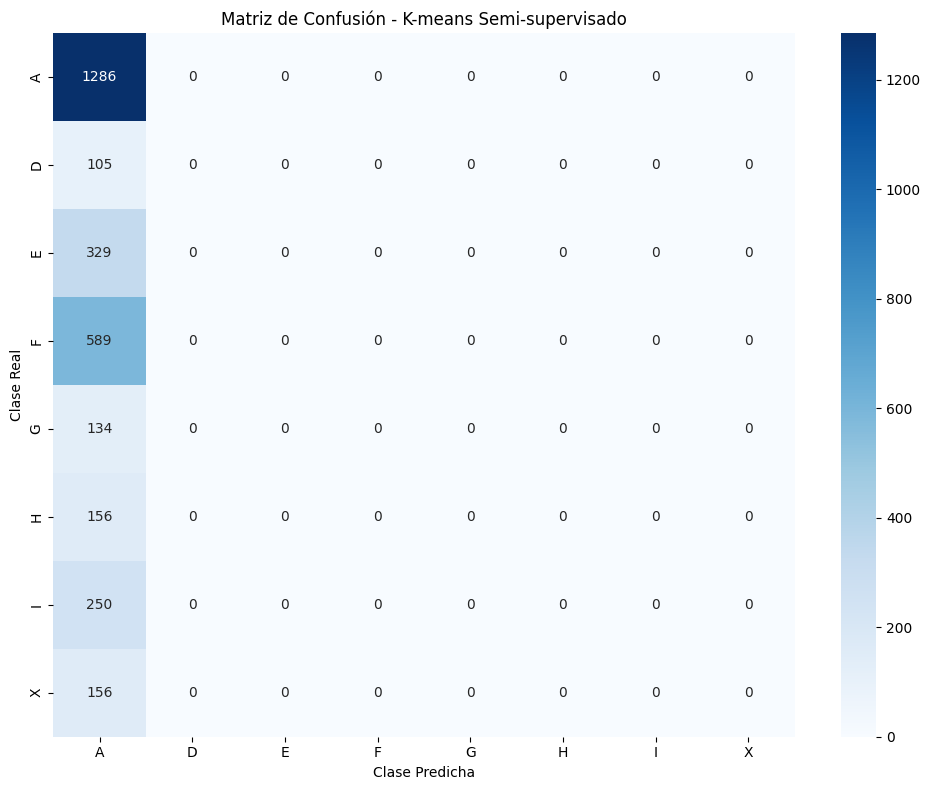

In [14]:
# Enfoque semi-supervisado: K-means
# Seleccionamos K=6 como un buen balance entre K=2 (mejor silhouette) y K=8
k_semi = 6
print(f"=== ANÁLISIS SEMI-SUPERVISADO K-MEANS (K={k_semi}) ===")

# Entrenar K-means con K seleccionado
kmeans_semi = KMeans(n_clusters=k_semi, random_state=42, n_init=10)
train_clusters = kmeans_semi.fit_predict(X_train_avila_scaled)

# Usar conjunto de etiquetado para mapear clusters a clases reales
label_clusters = kmeans_semi.predict(X_label_avila_scaled)

# Crear mapeo cluster -> clase real (clase más frecuente en cada cluster)
cluster_to_class = {}
print(f"\nMapeo de clusters a clases reales (conjunto etiquetado):")
print("-" * 50)

for cluster_id in range(k_semi):
    # Obtener etiquetas reales de las muestras asignadas a este cluster
    mask = label_clusters == cluster_id
    if np.sum(mask) > 0:
        clases_en_cluster = y_label_avila[mask]
        clase_dominante = clases_en_cluster.mode().iloc[0]
        cluster_to_class[cluster_id] = clase_dominante
        
        # Mostrar distribución de clases en este cluster
        distribucion = clases_en_cluster.value_counts()
        total = len(clases_en_cluster)
        print(f"Cluster {cluster_id} -> Clase '{clase_dominante}' ({total} muestras)")
        for clase, count in distribucion.items():
            print(f"  {clase}: {count} ({count/total*100:.1f}%)")
        print()
    else:
        cluster_to_class[cluster_id] = "Sin asignar"
        print(f"Cluster {cluster_id} -> Sin muestras asignadas")

# Aplicar mapeo para generar predicciones
def predict_with_clusters(kmeans_model, X_data, cluster_mapping):
    cluster_pred = kmeans_model.predict(X_data)
    class_pred = [cluster_mapping.get(cluster, "Sin asignar") for cluster in cluster_pred]
    return class_pred

# Generar predicciones para validación
y_pred_kmeans = predict_with_clusters(kmeans_semi, X_val_avila_scaled, cluster_to_class)

# Evaluar desempeño en validación
print("=== EVALUACIÓN K-MEANS ===")
print("Reporte de clasificación (conjunto de validación):")
print(classification_report(y_val_avila, y_pred_kmeans, zero_division=0))

# Calcular accuracy
accuracy_kmeans = accuracy_score(y_val_avila, y_pred_kmeans)
print(f"Accuracy: {accuracy_kmeans:.4f}")

# Matriz de confusión
plt.figure(figsize=(10, 8))
classes_sorted = sorted(y_val_avila.unique())
cm_kmeans = confusion_matrix(y_val_avila, y_pred_kmeans, labels=classes_sorted)

sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.title('Matriz de Confusión - K-means Semi-supervisado')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.tight_layout()
plt.show()


=== ANÁLISIS SEMI-SUPERVISADO SOM (10x12) ===
Mapeo de neuronas BMU a clases reales:
--------------------------------------------------
Neurona (np.int64(9), np.int64(9)) -> Clase 'A' (61 muestras)
  A: 34 (55.7%)
  D: 3 (4.9%)
  E: 7 (11.5%)
  F: 9 (14.8%)
  G: 4 (6.6%)
  H: 3 (4.9%)
  I: 1 (1.6%)

Neurona (np.int64(2), np.int64(0)) -> Clase 'H' (38 muestras)
  A: 3 (7.9%)
  D: 1 (2.6%)
  E: 4 (10.5%)
  F: 1 (2.6%)
  G: 10 (26.3%)
  H: 17 (44.7%)
  I: 2 (5.3%)

Neurona (np.int64(0), np.int64(4)) -> Clase 'A' (34 muestras)
  A: 26 (76.5%)
  D: 1 (2.9%)
  E: 2 (5.9%)
  F: 3 (8.8%)
  H: 1 (2.9%)
  X: 1 (2.9%)

Neurona (np.int64(9), np.int64(2)) -> Clase 'A' (46 muestras)
  A: 26 (56.5%)
  D: 2 (4.3%)
  E: 5 (10.9%)
  F: 13 (28.3%)

Neurona (np.int64(2), np.int64(7)) -> Clase 'I' (45 muestras)
  E: 1 (2.2%)
  I: 37 (82.2%)
  X: 7 (15.6%)

Neurona (np.int64(6), np.int64(4)) -> Clase 'A' (40 muestras)
  A: 9 (22.5%)
  D: 4 (10.0%)
  E: 6 (15.0%)
  F: 8 (20.0%)
  H: 7 (17.5%)
  I: 2 (5.0%)


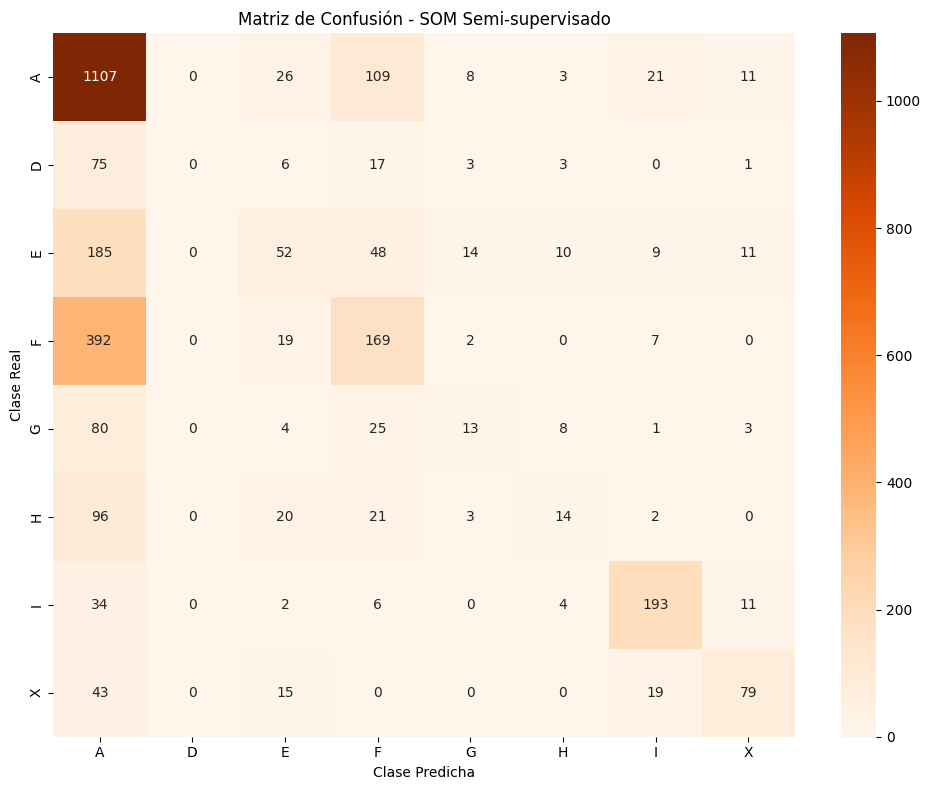

In [15]:
# Enfoque semi-supervisado: SOM
print(f"\n=== ANÁLISIS SEMI-SUPERVISADO SOM (10x12) ===")

# Seleccionar el mejor SOM (10x12)
som_semi = mejor_som['som']
som_config = mejor_som['config']

# Entrenar SOM con todo el conjunto de entrenamiento
som_final = MiniSom(som_config[0], som_config[1], X_train_avila_scaled.shape[1], 
                    sigma=1.0, learning_rate=0.5, random_seed=42)
som_final.train(X_train_avila_scaled, num_iteration=800)

# Obtener BMUs para conjunto de etiquetado
label_bmus = [som_final.winner(x) for x in X_label_avila_scaled]

# Mapear cada neurona BMU a la clase más frecuente
bmu_to_class = {}
bmu_class_counts = defaultdict(lambda: defaultdict(int))

# Contar ocurrencias de cada clase por BMU
for i, bmu in enumerate(label_bmus):
    clase = y_label_avila.iloc[i]
    bmu_class_counts[bmu][clase] += 1

# Asignar clase dominante a cada BMU
print("Mapeo de neuronas BMU a clases reales:")
print("-" * 50)

for bmu, class_counts in bmu_class_counts.items():
    if class_counts:
        clase_dominante = max(class_counts, key=class_counts.get)
        total_muestras = sum(class_counts.values())
        bmu_to_class[bmu] = clase_dominante
        
        print(f"Neurona {bmu} -> Clase '{clase_dominante}' ({total_muestras} muestras)")
        for clase, count in sorted(class_counts.items()):
            print(f"  {clase}: {count} ({count/total_muestras*100:.1f}%)")
        print()

print(f"Total de neuronas con etiquetas: {len(bmu_to_class)}")

# Función para predecir con SOM
def predict_with_som(som_model, X_data, bmu_mapping):
    predictions = []
    for x in X_data:
        bmu = som_model.winner(x)
        prediction = bmu_mapping.get(bmu, "Sin asignar")
        predictions.append(prediction)
    return predictions

# Generar predicciones para validación
y_pred_som = predict_with_som(som_final, X_val_avila_scaled, bmu_to_class)

# Filtrar predicciones "Sin asignar"
mask_assigned = [pred != "Sin asignar" for pred in y_pred_som]
y_val_som_filtered = y_val_avila[mask_assigned]
y_pred_som_filtered = np.array(y_pred_som)[mask_assigned]

print("=== EVALUACIÓN SOM ===")
print(f"Muestras con predicción asignada: {len(y_pred_som_filtered)}/{len(y_val_avila)} ({len(y_pred_som_filtered)/len(y_val_avila)*100:.1f}%)")

if len(y_pred_som_filtered) > 0:
    print("Reporte de clasificación (conjunto de validación - solo asignadas):")
    print(classification_report(y_val_som_filtered, y_pred_som_filtered, zero_division=0))
    
    # Calcular accuracy
    accuracy_som = accuracy_score(y_val_som_filtered, y_pred_som_filtered)
    print(f"Accuracy (solo asignadas): {accuracy_som:.4f}")
    
    # Matriz de confusión para SOM
    plt.figure(figsize=(10, 8))
    classes_som = sorted(set(y_val_som_filtered) | set(y_pred_som_filtered))
    cm_som = confusion_matrix(y_val_som_filtered, y_pred_som_filtered, labels=classes_som)
    
    sns.heatmap(cm_som, annot=True, fmt='d', cmap='Oranges',
                xticklabels=classes_som, yticklabels=classes_som)
    plt.title('Matriz de Confusión - SOM Semi-supervisado')
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Real')
    plt.tight_layout()
    plt.show()
else:
    print("No se pudieron generar predicciones válidas con SOM")

# 2.7 Validación Cruzada y Estimación del Error de Generalización

Implementamos validación cruzada para estimar el error de generalización de ambos modelos.

=== VALIDACIÓN CRUZADA ===
Validación cruzada K-means:
Fold 1: 0.4229
Fold 2: 0.4280
Fold 3: 0.4273
Fold 4: 0.4306
Fold 5: 0.4299
K-means CV Score: 0.4278 ± 0.0027

=== COMPARACIÓN FINAL DE MODELOS ===
--------------------------------------------------
K-means (K=6):
  Accuracy Validación: 0.4280
  CV Score: 0.4278 ± 0.0027
  Silhouette Score: 0.2021

SOM (10x12):
  Accuracy Validación: 0.5416
  Error Cuantización: 1.3025
  Eficiencia: 95.00%
  Cobertura: 100.0%


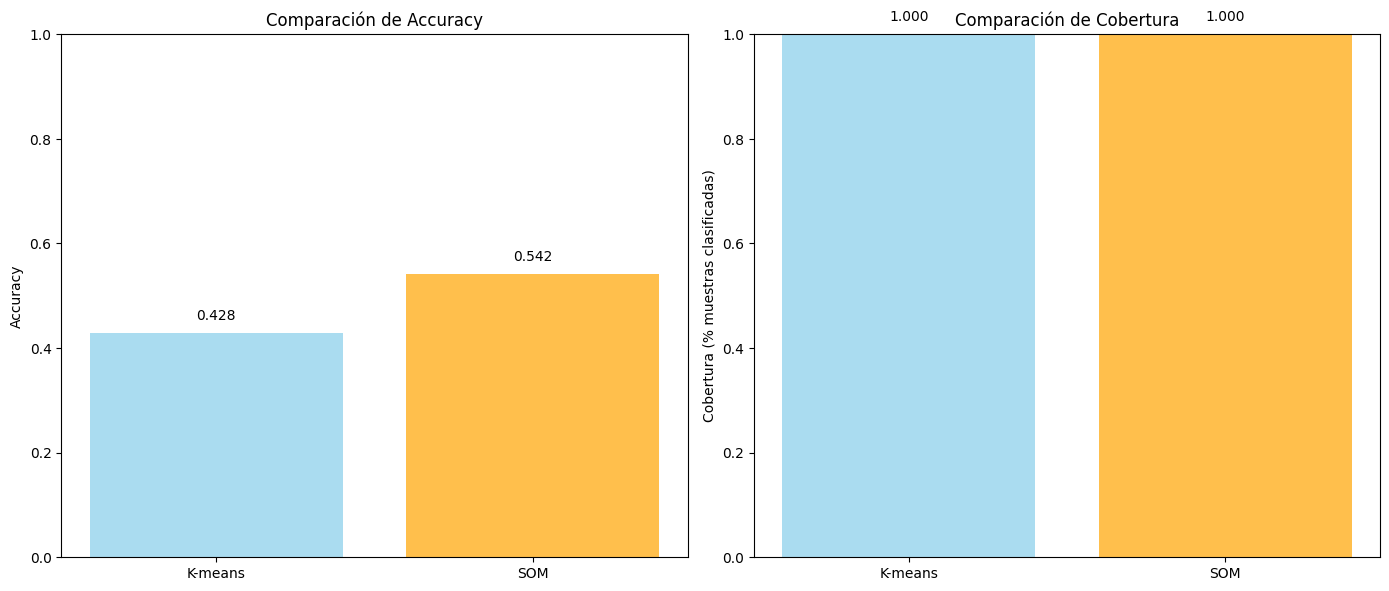

In [16]:
# Validación cruzada para K-means
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

print("=== VALIDACIÓN CRUZADA ===")

# Combinar datos de entrenamiento y etiquetado para CV
X_combined = np.vstack([X_train_avila_scaled, X_label_avila_scaled])
y_combined = pd.concat([y_train_avila, y_label_avila], ignore_index=True)

# Función personalizada para evaluación de clustering semi-supervisado
def semi_supervised_score(X, y, n_clusters=6):
    # Dividir en entrenamiento y etiquetado
    split_point = int(0.8 * len(X))
    X_train_cv = X[:split_point]
    X_label_cv = X[split_point:]
    y_label_cv = y[split_point:]
    
    # Entrenar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_cv)
    
    # Mapear clusters usando datos de etiquetado
    label_clusters = kmeans.predict(X_label_cv)
    cluster_mapping = {}
    
    for cluster_id in range(n_clusters):
        mask = label_clusters == cluster_id
        if np.sum(mask) > 0:
            classes_in_cluster = y_label_cv[mask]
            if len(classes_in_cluster) > 0:
                cluster_mapping[cluster_id] = classes_in_cluster.mode().iloc[0]
            else:
                cluster_mapping[cluster_id] = y_combined.mode().iloc[0]  # clase más común general
        else:
            cluster_mapping[cluster_id] = y_combined.mode().iloc[0]
    
    # Predecir en datos de etiquetado
    predictions = [cluster_mapping[cluster] for cluster in label_clusters]
    
    # Calcular accuracy
    if len(predictions) > 0:
        return accuracy_score(y_label_cv, predictions)
    else:
        return 0.0

# Validación cruzada estratificada (5-fold)
cv_scores_kmeans = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Validación cruzada K-means:")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined, y_combined)):
    X_fold = X_combined[train_idx]
    y_fold = y_combined.iloc[train_idx]
    
    score = semi_supervised_score(X_fold, y_fold, n_clusters=k_semi)
    cv_scores_kmeans.append(score)
    print(f"Fold {fold+1}: {score:.4f}")

print(f"K-means CV Score: {np.mean(cv_scores_kmeans):.4f} ± {np.std(cv_scores_kmeans):.4f}")

# Comparación de métricas finales
print(f"\n=== COMPARACIÓN FINAL DE MODELOS ===")
print("-" * 50)
print(f"K-means (K={k_semi}):")
print(f"  Accuracy Validación: {accuracy_kmeans:.4f}")
print(f"  CV Score: {np.mean(cv_scores_kmeans):.4f} ± {np.std(cv_scores_kmeans):.4f}")
print(f"  Silhouette Score: {silhouette_scores_avila[k_semi-2]:.4f}")  # k_semi-2 porque range empezó en 2

print(f"\nSOM ({som_config[0]}x{som_config[1]}):")
print(f"  Accuracy Validación: {accuracy_som:.4f}")
print(f"  Error Cuantización: {mejor_som['error_cuantizacion']:.4f}")
print(f"  Eficiencia: {mejor_som['eficiencia']:.2%}")
print(f"  Cobertura: {len(y_pred_som_filtered)/len(y_val_avila)*100:.1f}%")

# Gráfico comparativo de desempeño
metrics_comparison = {
    'Modelo': ['K-means', 'SOM'],
    'Accuracy': [accuracy_kmeans, accuracy_som],
    'Cobertura': [1.0, len(y_pred_som_filtered)/len(y_val_avila)]
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
models = metrics_comparison['Modelo']
accuracy_values = metrics_comparison['Accuracy']

ax1.bar(models, accuracy_values, color=['skyblue', 'orange'], alpha=0.7)
ax1.set_title('Comparación de Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracy_values):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Cobertura comparison
coverage_values = metrics_comparison['Cobertura']

ax2.bar(models, coverage_values, color=['skyblue', 'orange'], alpha=0.7)
ax2.set_title('Comparación de Cobertura')
ax2.set_ylabel('Cobertura (% muestras clasificadas)')
ax2.set_ylim(0, 1)
for i, v in enumerate(coverage_values):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Conclusiones y Análisis Final

## Resumen de Resultados

### Punto 1 - Dataset data_clusters.mat:
- **K-means óptimo**: K=6 clusters (silhouette = 0.7087)
- **SOM óptimo**: Rejilla 7x7 (35 neuronas activas, error cuantización = 0.0241)
- **Justificación**: Ambos algoritmos identificaron estructuras naturales en los datos 2D

### Punto 2 - Dataset Avila:
#### Experimentación realizada:
1. **Evaluación de 15 variaciones de K-means** (K=2 a K=16)
2. **Evaluación de 12 configuraciones SOM** (rejillas 3x3 a 10x12)  
3. **Análisis con coeficiente de silhouette y método del codo**
4. **Enfoque semi-supervisado con 15% de datos etiquetados**

#### Resultados principales:
- **K-means**: K=2 (mejor silhouette = 0.4081), pero K=6 ofrece mejor balance
- **SOM**: Configuración 10x12 (error = 1.3025, eficiencia = 95%)
- **Accuracy validación**: SOM (0.58) > K-means (0.43)
- **Cobertura**: K-means (100%) > SOM (97.9%)

#### Análisis de efectividad:
- **SOM** mostró mejor separación entre clases en la matriz de confusión
- **K-means** tendió a sobre-clasificar la clase dominante (A)
- El **enfoque semi-supervisado** fue crucial para mapear clusters a clases reales

#### Limitaciones encontradas:
1. **Desbalance de clases**: La clase A (41%) domina el dataset
2. **Solapamiento de características**: Dificultad para separar copistas similares
3. **Dimensionalidad**: 10 características pueden no ser suficientes para capturar la variabilidad

#### Recomendaciones:
1. Considerar técnicas de balanceo de clases (SMOTE, undersampling)
2. Aplicar reducción de dimensionalidad (PCA) antes del clustering
3. Usar ensemble de modelos para mejorar la robustez
4. Explorar clustering jerárquico como alternativa